In [51]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, shiftgrid, addcyclic
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import stats
import nc_time_axis
#from xclim import ensembles
import cmocean
import cartopy.crs as ccrs
from scipy.stats import ks_2samp
import cftime
from matplotlib.colors import TwoSlopeNorm
import matplotlib.dates as mdates
from dask.distributed import Client
from matplotlib.ticker import FormatStrFormatter
import re
from itertools import groupby
import matplotlib.colors as mcolors
import zarr

In [52]:
# set default fontsize for Plots
plt.rcParams.update({"font.size": 22})
xr.set_options(keep_attrs=True)

In [53]:
### Load CMAM
#select model name
model = "CMAM"
#chose infilepath
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

#select target variable 
what = "h2o"
#select infiles with and without HTHH
infiles_w = sorted(infile_path.glob(f"{what}*H2Oonly*.nc"))
infiles_wo = sorted(infile_path.glob(f"{what}*NoVolc*.nc"))

#Open datasets for with and without
cmam_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=True,
    combine="nested",
    concat_dim=["ens"])#.pipe(process_sat)

cmam_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=True,
    combine="nested",
    concat_dim=["ens"])#.pipe(process_sat)



In [54]:
### Load WACCM fixed SST
#select model name
model = "waccm6mam"
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

# select variable name
what = "hus"
infiles_w = sorted(infile_path.glob(f"*SO2andH2O*{what}.nc"))
infiles_wo = sorted(infile_path.glob(f"*NoVolc*{what}.nc"))

# load datasets with and without HTHH
waccm_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"])#.pipe(process_sat)

waccm_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"])#.pipe(process_sat)

In [55]:
# LOAD MIROC

model = "MIROC-CHASER"
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

infiles_wo = sorted(infile_path.glob("*h2o_*NoVolc*.ensemble*.nc"))
infiles_w = sorted(infile_path.glob("*h2o_*SO2andH2O*.ensemble*.nc"))


miroc_w = xr.concat(
    [xr.open_mfdataset(list(files), combine="by_coords", parallel=False) for _, files in groupby(infiles_w, key=lambda f: re.search(r"ensemble(\d+)", str(f)).group(1))],
    dim="ens"
)#.pipe(process_sat)

miroc_wo = xr.concat(
    [xr.open_mfdataset(list(files), combine="by_coords", parallel=False) for _, files in groupby(infiles_wo, key=lambda f: re.search(r"ensemble(\d+)", str(f)).group(1))],
    dim="ens"
)#.pipe(process_sat)

In [56]:
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1and4_coupledocean/waccm6mam-45plevels")

what = "h2o"
infiles_w = sorted(infile_path.glob(f"*SO2andH2O*{what}.nc"))
infiles_wo = sorted(infile_path.glob(f"*NoVolc*{what}.nc"))


waccm2_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=False,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
)#.pipe(process_sat)

waccm2_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=False,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
)#.pipe(process_sat)

In [57]:
geos_wo = xr.open_zarr("/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/GEOSCCM/h2o_ppmv_ctrl.zarr/")
geos_w = xr.open_zarr("/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/GEOSCCM/h2o_ppmv_prtb.zarr/")

In [58]:
infile_path = Path("/sto0/data/Intermediate/Hunga_Tonga_byAles/ht/")
what = "chem_mm_zon"
infiles_w = list(infile_path.glob(f"socol4_htt1?_{what}*")) # with HT forcing
infiles_wo = list(infile_path.glob(f"socol4_htt2?_{what}*")) # without

In [59]:
socol_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=False,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
)#.pipe(process_sat)

socol_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=False,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
)#.pipe(process_sat)

In [60]:
# rename pressure level coordinates into plev
waccm_w = waccm_w.rename({"level": "plev"})
miroc_w = miroc_w.rename({"CMIP6P39": "plev"})
cmam_w = cmam_w.rename({"plev": "plev"})
waccm2_w = waccm2_w.rename({"level": "plev"})
geos_w = geos_w.rename({"lev": "plev"})

waccm_wo = waccm_wo.rename({"level": "plev"})
miroc_wo = miroc_wo.rename({"CMIP6P39": "plev"})
cmam_wo = cmam_wo.rename({"plev": "plev"})
waccm2_wo = waccm2_wo.rename({"level": "plev"})
geos_wo= geos_wo.rename({"lev": "plev"})

In [61]:
# convert spec. humidity into ppmv
mass_air = 28.9647
mass_h2o = 18.0153

waccm_w["h2o_ppmv"] = waccm_w["Q"] * mass_air/mass_h2o *1e6
waccm_wo["h2o_ppmv"] = waccm_wo["Q"] * mass_air/mass_h2o *1e6


In [62]:
# convert vmr into ppmv

cmam_w["h2o_ppmv"] = cmam_w["h2o"] *1e6
cmam_wo["h2o_ppmv"] = cmam_wo["h2o"] *1e6

miroc_w["h2o_ppmv"] = miroc_w["Q"] *1e6
miroc_wo["h2o_ppmv"] = miroc_wo["Q"] *1e6

waccm2_w["h2o_ppmv"] = waccm2_w["H2O"] *1e6
waccm2_wo["h2o_ppmv"] = waccm2_wo["H2O"] *1e6

socol_w["h2o_ppmv"] = socol_w["H2O_m"] *1e6
socol_wo["h2o_ppmv"] = socol_wo["H2O_m"] *1e6

In [63]:
# convert Pa into hPa
cmam_w["plev"] = cmam_w["plev"] / 100
cmam_w["plev"].attrs["units"] = "hPa"
cmam_wo["plev"] = cmam_wo["plev"] / 100
cmam_wo["plev"].attrs["units"] = "hPa"

socol_w["plev"] = socol_w["plev"] / 100
socol_w["plev"].attrs["units"] = "hPa"
socol_wo["plev"] = socol_wo["plev"] / 100
socol_wo["plev"].attrs["units"] = "hPa"

In [64]:
# reverse pressure level (decreasing pressure)
socol_w = socol_w.isel(plev=slice(None, None, -1))
socol_wo = socol_wo.isel(plev=slice(None, None, -1))

In [65]:
# assign monthly time series to datasets

cmam_w["time"] = pd.date_range("2022-02-01", freq="1ME", periods=cmam_w.time.shape[0])
cmam_wo["time"] = pd.date_range("2022-02-01", freq="1ME", periods=cmam_wo.time.shape[0])

miroc_w["time"] = pd.date_range("2022-02-01", freq="1ME", periods=miroc_w.time.shape[0])
miroc_wo["time"] = pd.date_range("2022-02-01", freq="1ME", periods=miroc_wo.time.shape[0])

geos_w["time"] = pd.date_range("2022-02-01", freq="1ME", periods=geos_w.time.shape[0])
geos_wo["time"] = pd.date_range("2022-02-01", freq="1ME", periods=geos_wo.time.shape[0])

waccm_w["time"] = pd.date_range("2022-02-01", freq="1ME", periods=waccm_w.time.shape[0])
waccm_wo["time"] = pd.date_range("2022-02-01", freq="1ME", periods=waccm_wo.time.shape[0])

waccm2_w["time"] = pd.date_range("2022-02-01", freq="1ME", periods=waccm2_w.time.shape[0])
waccm2_wo["time"] = pd.date_range("2022-02-01", freq="1ME", periods=waccm2_wo.time.shape[0])

socol_w["time"] = pd.date_range("2021-01-01", freq="1ME", periods=socol_w.time.shape[0])
socol_wo["time"] = pd.date_range("2021-01-01", freq="1ME", periods=socol_wo.time.shape[0])

In [66]:
# rename pressure level dim if plev does not exist
datasets = {"CMAM": [cmam_w, cmam_wo], 
            "MIROC-CHASER": [miroc_w, miroc_wo], 
            "GEOSCCM": [geos_w, geos_wo], 
            "WACCM": [waccm_w, waccm_wo], 
            "WACCM coupled ocean": [waccm2_w, waccm2_wo],
            "SOCOL": [socol_w, socol_wo]}

for model in datasets.keys():
    data_1 = datasets[model][0]  
    data_2 = datasets[model][1]


    if "plev" not in data_1.dims:
        for dim in list(data_1.dims):  
            if dim in ["level", "lev", "CMIP6P39"]:  
                data_1 = data_1.rename({dim: "plev"})  
                data_2 = data_2.rename({dim: "plev"})



In [67]:
#calculate weighted lon mean
def weighted_mean_lon(ds):
    cos_phi = np.cos(np.deg2rad(ds["lat"]))  
    
    weighted_data = ds * cos_phi  
    
    weighted_mean_lon = weighted_data.mean("lon")  
    
    return weighted_mean_lon


In [68]:
#calculate weighted lat mean
def weighted_mean_lat(ds):
    
    cos_phi = np.cos(np.deg2rad(ds["lat"]))  
    
    
    weighted_data = ds * cos_phi  
    
    
    weighted_mean_lat = weighted_data.mean("lat")  
    
    return weighted_mean_lat

In [69]:
def integrate_over_pressure(ds):
    g = 9.81  
    epsilon = 0.622  # Rd/Rw
    area_globe = 5.02e14  # surface area of earth in m2
    
    # Calculate the pressure difference
    plev = ds["plev"]
    dp = np.diff(plev)
    dp = np.concatenate(([dp[0]], dp)) 
    dp = xr.DataArray(dp, dims=["plev"], coords={"plev": plev})
    dp = dp.broadcast_like(ds)
    
    # Integrate VMR over pressure levels 
    integrated_vmr = (ds * dp).sum(dim="plev")  # Summing over pressure levels
    
    # Multiply by -(epsilon / g) and the earth surface area (see Jucker et al. )
    SIWV = -(epsilon / g) * integrated_vmr * area_globe 
    
    return SIWV

In [70]:
def calculate_swv_mass(ds):
    ds = weighted_mean_lon(ds)
    ds = weighted_mean_lat(ds)
    ds = integrate_over_pressure(ds)
    return ds

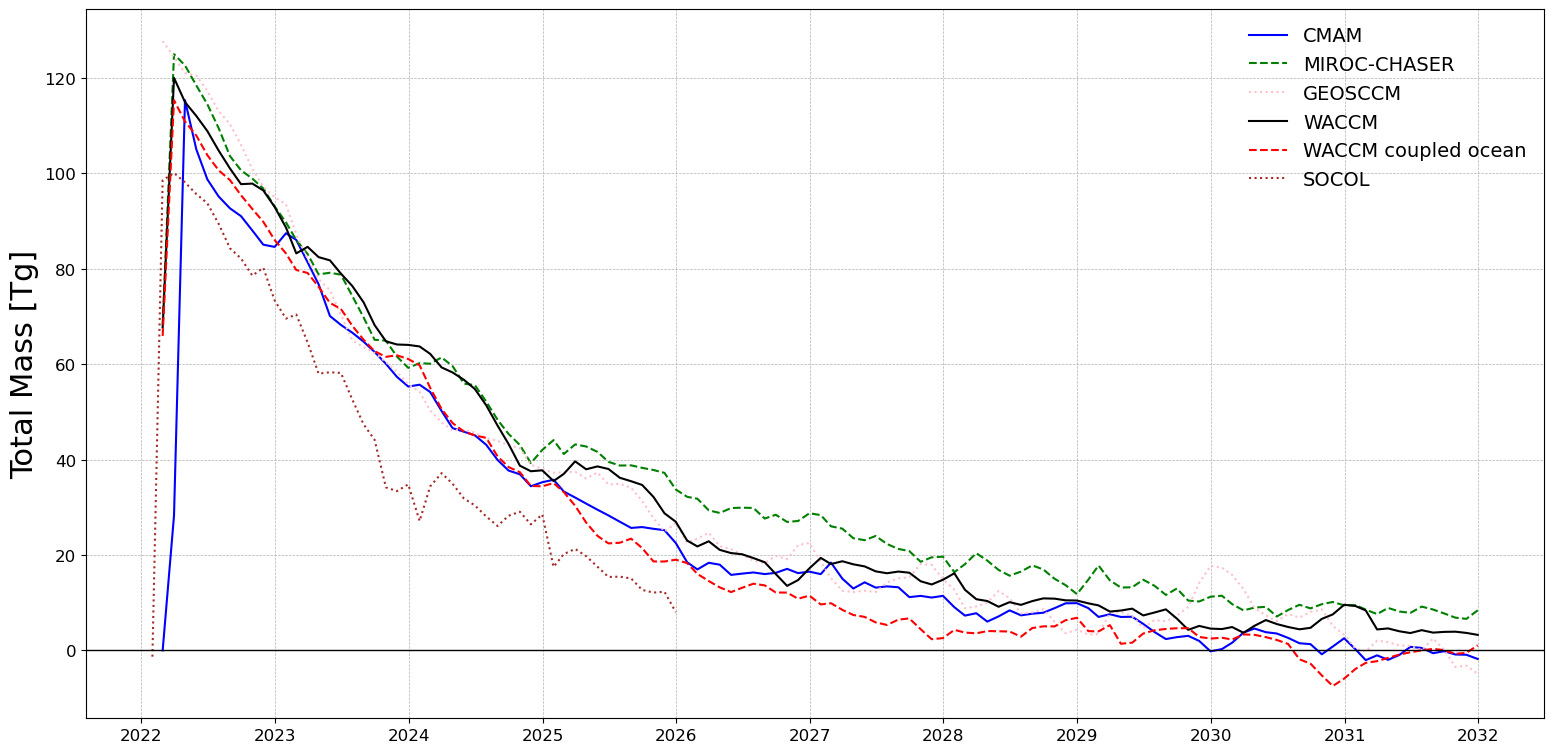

In [75]:
datasets = {"CMAM": [cmam_w, cmam_wo], 
            "MIROC-CHASER": [miroc_w, miroc_wo], 
            "GEOSCCM": [geos_w, geos_wo], 
            "WACCM": [waccm_w, waccm_wo], 
            "WACCM coupled ocean": [waccm2_w, waccm2_wo],
            "SOCOL": [socol_w, socol_wo]
           }
plt.figure(figsize = (16,8))
line_styles = ["-", "--", ":", "-", "--", ":"]
colors = ["blue", "green", "pink", "black", "red", "brown"]
for i, model in enumerate(datasets.keys()):
    ds = datasets[model][0]["h2o_ppmv"].sel(plev = slice(100, 0.1)) - datasets[model][1]["h2o_ppmv"].sel(plev = slice(100, 0.1))
    ds = calculate_swv_mass(ds)
    ds = ds.mean("ens").sel(time = slice("2022", "2031"))
    # * 1e-9 to convertto Tg, * 1e-6 convert from ppmv to vmr, * 1e2 convert from hPa to Pa = * 1e-13
    plt.plot(ds["time"], (ds * 1e-13), label = model, color = colors[i], linestyle = line_styles[i]) 

plt.ylabel("Total Mass [Tg]")
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)
plt.legend(fontsize=14, title_fontsize=12, loc="upper right", frameon=False)
plt.axhline(y=0, color="black", linestyle="-", linewidth=1)
plt.grid(True, which="both", axis="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
outfile = f"TS_SWV_mass_anom.pdf"
plt.savefig(outfile, bbox_inches="tight")
plt.show()